In [22]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats
from syntren import *
from gnw import *

In [38]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]
nb_train, nb_genes = expr_train.shape

# Find minimum and maximum expression values
r_min = np.min(expr_train)
r_max = np.max(expr_train)

### GAN data ###
synthetic_name = 'EColi_n{}_r{}_e{}_d{}'.format(len(gene_symbols), root_gene, minimum_evidence, max_depth)
s_expr, s_gs = load_synthetic(synthetic_name)
assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Clip outliers
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

gan_expr = s_expr

### SynTReN data ###
s_expr, s_gene_symbols = syntren_results(minimum_evidence='Weak',
                                         nb_background=0)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of SynTReN data
r_min = r_expr.min(axis=0)
r_max = r_expr.max(axis=0)
s_expr = s_expr*(r_max - r_min) + r_min

syn_expr = s_expr[:nb_train, :]

### GNW data ###
s_expr, s_gene_symbols = gnw_results(minimum_evidence='Weak',
                                     break_loops=False)

# Align synthetic gene symbols
idxs = [s_gene_symbols.index(gene) for gene in gene_symbols]
s_expr = s_expr[:, idxs]
assert (np.array(s_gene_symbols)[idxs] == np.array(gene_symbols)).all()

# Adjust scale of GNW data
s_expr = s_expr*(r_max - r_min) + r_min
s_expr = s_expr[:nb_train, :]

gnw_expr = s_expr

Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...
(680, 1076)


# Intensity histograms

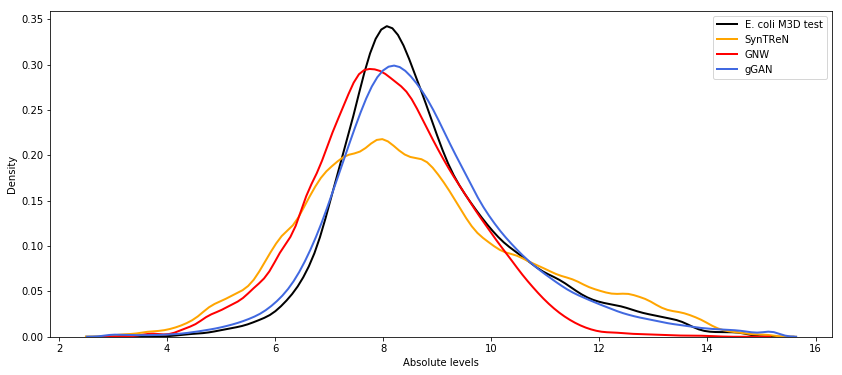

In [39]:
plt.figure(figsize=(14, 6))
# ax = plot_intensities(expr_train, dataset_name='E. coli M3D train', plot_quantiles=False)
ax = plot_intensities(expr_test, dataset_name='E. coli M3D test', color='black', plot_quantiles=False)
ax = plot_intensities(syn_expr, dataset_name='SynTReN', color='orange', plot_quantiles=False, ax=ax);
ax = plot_intensities(gnw_expr, dataset_name='GNW', color='red', plot_quantiles=False, ax=ax)
ax = plot_intensities(gan_expr, dataset_name='gGAN', color='royalblue', plot_quantiles=False, ax=ax);

# Gene ranges histograms

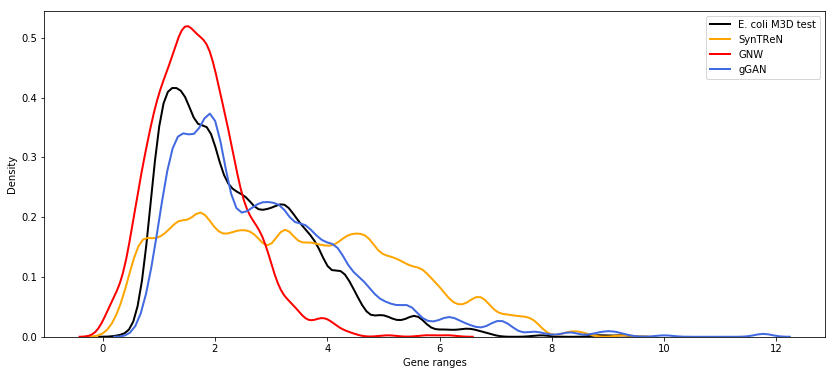

In [40]:
plt.figure(figsize=(14, 6))
# ax = plot_gene_ranges(expr_train, dataset_name='E. coli M3D train')
ax = plot_gene_ranges(expr_test, dataset_name='E. coli M3D test', color='black')
ax = plot_gene_ranges(syn_expr, dataset_name='SynTReN', color='orange', ax=ax)
ax = plot_gene_ranges(gnw_expr, dataset_name='GNW', color='red', ax=ax)
plot_gene_ranges(gan_expr, dataset_name='gGAN', color='royalblue', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [41]:
train_tf_tg_corr, train_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_test, gene_symbols)
syn_tf_tg_corr, syn_tg_tg_corr = compute_tf_tg_corrs(syn_expr, gene_symbols)
gnw_tf_tg_corr, gnw_tg_tg_corr = compute_tf_tg_corrs(gnw_expr, gene_symbols)
gan_tf_tg_corr, gan_tg_tg_corr = compute_tf_tg_corrs(gan_expr, gene_symbols)
train_back_corr = correlations_list(expr_train, expr_train)
r_back_corr = correlations_list(expr_test, expr_test)
syn_back_corr = correlations_list(syn_expr, syn_expr)
gnw_back_corr = correlations_list(gnw_expr, gnw_expr)
gan_back_corr = correlations_list(gan_expr, gan_expr)

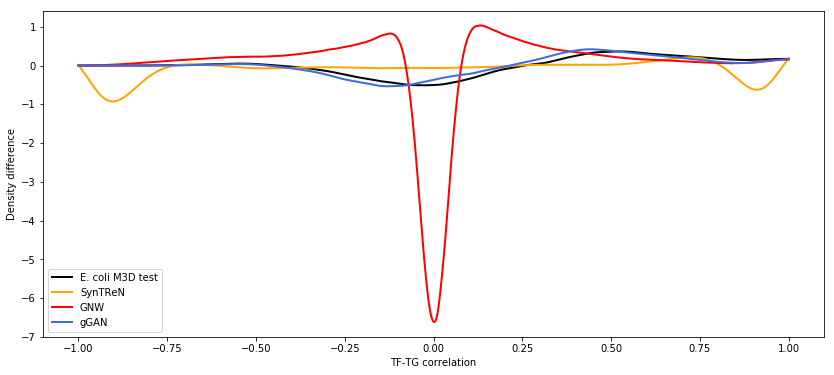

In [42]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation', dataset_name='E. coli M3D test', color='black')
ax = plot_difference_histogram(syn_tf_tg_corr, syn_back_corr, 'TF-TG correlation', dataset_name='SynTReN', color='orange', ax=ax); 
ax = plot_difference_histogram(gnw_tf_tg_corr, gnw_back_corr, 'TF-TG correlation', dataset_name='GNW', color='red', ax=ax); 
plot_difference_histogram(gan_tf_tg_corr, gan_back_corr, 'TF-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

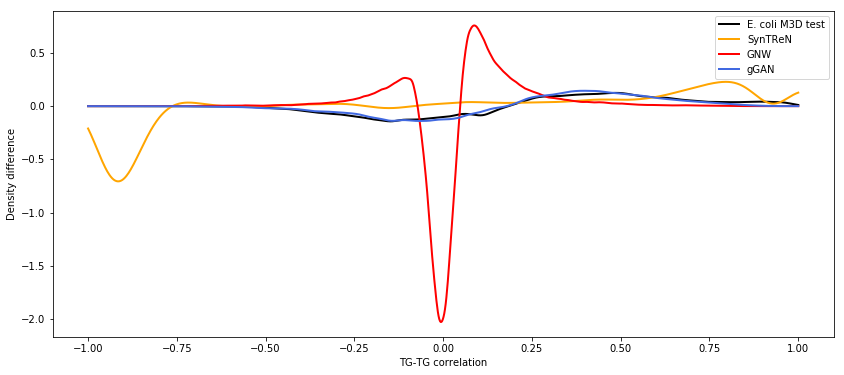

In [43]:
plt.figure(figsize=(14, 6))
# ax = plot_difference_histogram(train_tg_tg_corr, train_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D train', color='green')
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation', dataset_name='E. coli M3D test', color='black', ax=ax)
ax = plot_difference_histogram(syn_tg_tg_corr, syn_back_corr, 'TG-TG correlation', dataset_name='SynTReN', color='orange', ax=ax);
ax = plot_difference_histogram(gnw_tg_tg_corr, gnw_back_corr, 'TG-TG correlation', dataset_name='GNW', color='red', ax=ax);
ax = plot_difference_histogram(gan_tg_tg_corr, gan_back_corr, 'TG-TG correlation', dataset_name='gGAN', color='royalblue', ax=ax);

# Compare background distributions

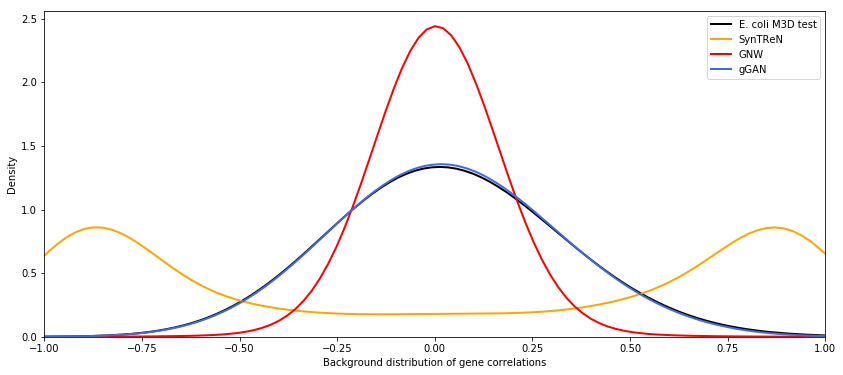

In [44]:
plt.figure(figsize=(14, 6))
# ax = plot_distribution(train_back_corr, label='E. coli M3D train')
ax = plot_distribution(r_back_corr, label='E. coli M3D test', color='black')
ax = plot_distribution(syn_back_corr, label='SynTReN', color='orange', ax=ax)
ax = plot_distribution(gnw_back_corr, label='GNW', color='red', ax=ax)
ax = plot_distribution(gan_back_corr, xlabel='Background distribution of gene correlations', ylabel='Density', label='gGAN', color='royalblue')
ax.set_xlim((-1, 1));

# TF activity histogram

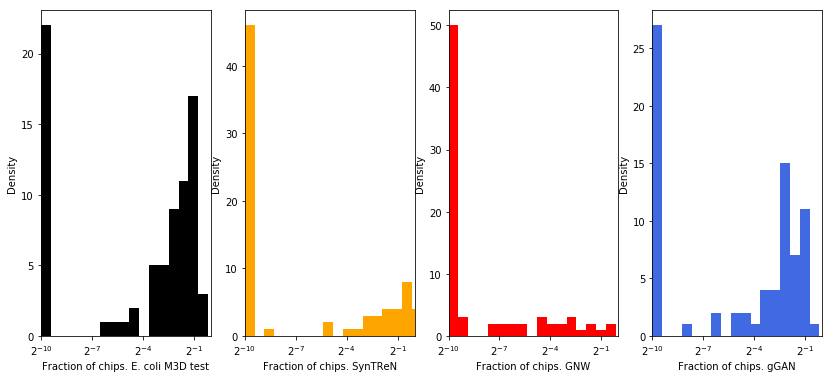

In [45]:
plt.figure(figsize=(14, 6))
plt.subplot(141)
plot_tf_activity_histogram(expr_test, gene_symbols, xlabel='Fraction of chips. E. coli M3D test', color='black')
plt.subplot(142)
plot_tf_activity_histogram(syn_expr, gene_symbols, xlabel='Fraction of chips. SynTReN', color='orange')
plt.subplot(143)
plot_tf_activity_histogram(gnw_expr, gene_symbols, xlabel='Fraction of chips. GNW', color='red')
plt.subplot(144)
plot_tf_activity_histogram(gan_expr, gene_symbols, xlabel='Fraction of chips. gGAN', color='royalblue');